<a href="https://colab.research.google.com/github/z-gursky/Medical-Costs-/blob/main/Health_Care_Medical_Costs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as ltb
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
import scipy
from sklearn import linear_model
%matplotlib inline

In [ ]:
from google.colab import files
data_to_load = files.upload()

Saving medical_costs.csv to medical_costs (4).csv


In [ ]:
import io
medical_costs_df = pd.read_csv(io.BytesIO(data_to_load['medical_costs.csv']))
medical_costs = medical_costs_df.copy()

Columns

age: age of primary beneficiary

sex: insurance contractor gender, female, male

bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

children: Number of children covered by health insurance / Number of dependents

smoker: Smoking

region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

charges: Individual medical costs billed by health insurance

In [ ]:
medical_costs

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [ ]:
# Which data is missing and how much? 
medical_costs.isnull().sum()*100/medical_costs.isnull().count()

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

In [ ]:
medical_costs.drop(['children', 'region'], axis=1, inplace=True)

In [ ]:
# one hot encoding to convert Gendre from string to binary value
medical_costs["is_male"] = pd.get_dummies(medical_costs.sex, drop_first=True)
medical_costs["is_smoker"] = pd.get_dummies(medical_costs.smoker, drop_first=True)
medical_costs.drop(['smoker'], axis=1, inplace=True)
medical_costs.drop(['sex'], axis=1, inplace=True)

In [ ]:
medical_costs

,age,bmi,charges,is_male,is_smoker
0,19,27.900,16884.92400,0,1
1,18,33.770,1725.55230,1,0
2,28,33.000,4449.46200,1,0
3,33,22.705,21984.47061,1,0
4,32,28.880,3866.85520,1,0
...,...,...,...,...,...
1333,50,30.970,10600.54830,1,0
1334,18,31.920,2205.98080,0,0
1335,18,36.850,1629.83350,0,0
1336,21,25.800,2007.94500,0,0


### ***EDA***

Mean: $13270


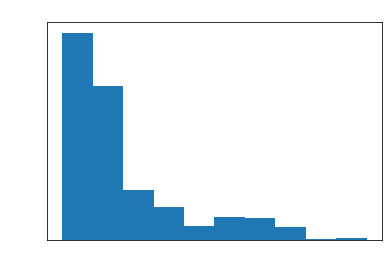

In [ ]:
print('Mean: ${}'.format(round(np.mean(medical_costs.charges))))
with plt.rc_context({'xtick.color':'white', 'ytick.color':'white',
                     'axes.labelcolor': 'white'}):
  plt.hist(medical_costs.charges)
  plt.title('Insurance Cost Distribution', color='white')
  plt.xlabel('Cost', color='white')
  plt.xticks()
  plt.ylabel('Number of Occurances', color='white')
  plt.show()

Doesn't appear to be normally distrubuted.

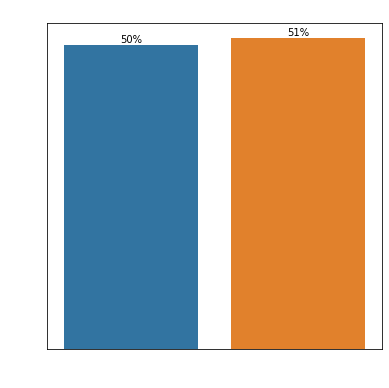

In [ ]:
with plt.rc_context({'xtick.color':'white', 'ytick.color':'white',
                     'axes.labelcolor': 'white'}): 
  total = len(medical_costs.value_counts())
  plt.figure(figsize = (6, 6))
  plt.title('Gender count', color='white')
  ax = sns.countplot(x="is_male", data=medical_costs)
  for p in ax.patches:
      percentage = '{:.0f}%'.format(p.get_height() / total * 100)
      x = p.get_x() + p.get_width() / 2
      y = p.get_height() + 5
      ax.annotate(percentage, (x, y), ha = 'center')
  plt.show()

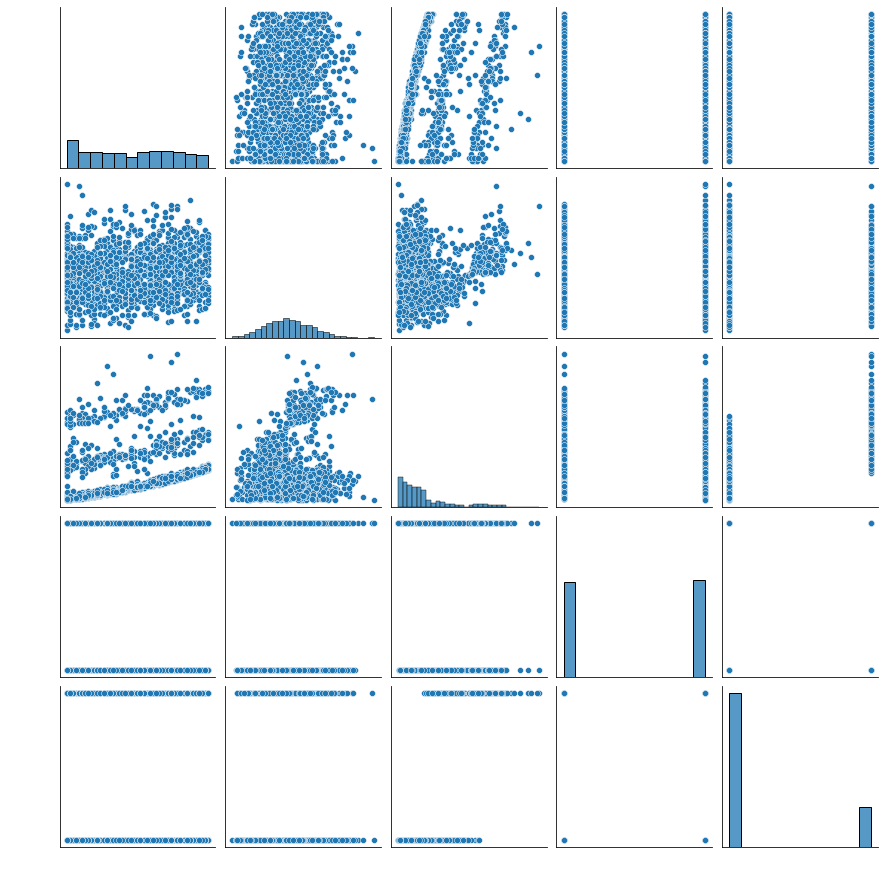

In [ ]:
# correlation between variables
with plt.rc_context({'xtick.color':'white', 'ytick.color':'white', 
                     'axes.labelcolor': 'white'}):
  sns.pairplot(data=medical_costs)

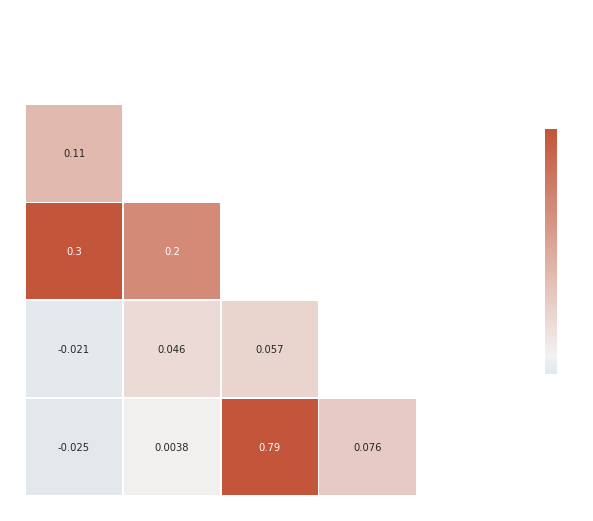

In [ ]:
# heat matrix between variables
with plt.rc_context({'xtick.color':'white', 'ytick.color':'white', 
                     'axes.labelcolor': 'white'}):
  corr = medical_costs.corr()

# Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
  cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio

  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

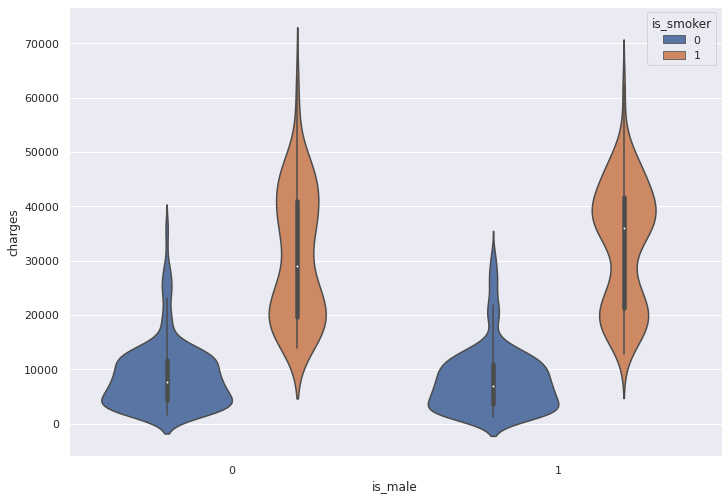

In [ ]:
with plt.rc_context({'xtick.color':'white', 'ytick.color':'white', 'axes.labelcolor': 'white'}):
  sns.set(rc={'figure.figsize':(11.7,8.27)})
  ax = sns.violinplot(x="is_male", y="charges", hue='is_smoker', data=medical_costs)

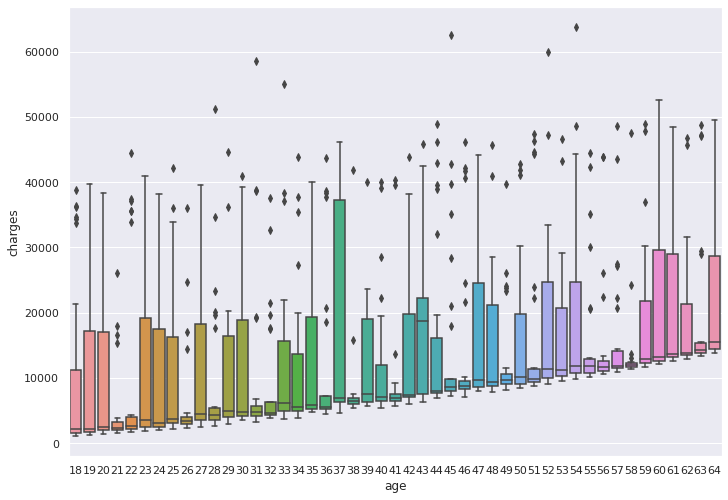

In [ ]:
with plt.rc_context({'xtick.color':'white', 'ytick.color':'white', 'axes.labelcolor': 'white'}):
  sns.set(rc={'figure.figsize':(11.7,8.27)})
  sns.boxplot(x='age', y='charges', data=medical_costs)

In [ ]:
with plt.rc_context({'xtick.color':'white', 'ytick.color':'white', 'axes.labelcolor': 'white'}):
  sns.set(rc={'figure.figsize':(11.7,8.27)})
  sns.boxplot(x='age', y='charges', data=medical_costs)

AttributeError: ignored

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


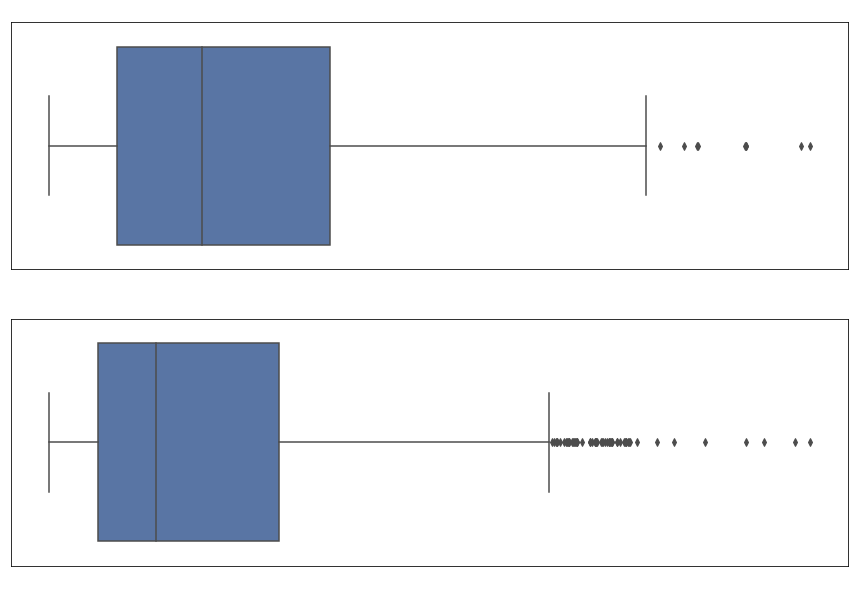

In [ ]:
with plt.rc_context({'xtick.color':'white', 'ytick.color':'white', 'axes.labelcolor': 'white'}):
  plt.figure(figsize=(15,10))
  
  plt.subplot(2,1,1)
  plt.title("Distribution of charges for patients with BMI less than 30", color='white')
  ax = sns.boxplot(medical_costs[(medical_costs.bmi < 30)]['charges'], color = 'b')

  plt.subplot(2,1,2)
  plt.title("Distribution of charges for patients with BMI 30 or greater", color='white')
  ax = sns.boxplot(medical_costs[(medical_costs.bmi >= 30)]['charges'], color = 'b')

In [ ]:
medical_costs["bmi_is_smoker"] = medical_costs.bmi * medical_costs.is_smoker

There are some outliers but with the dataset looking at medical costs I will not handle these. 

In [ ]:
import statsmodels.api as sm
# `Y` is the target variable
Y = medical_costs['charges']
# `X` is the feature set which includes the
# `is_male` and `is_smoker` variables
X = medical_costs[['is_male','is_smoker', 'age', 'bmi']]

# You need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     986.5
Date:                Thu, 21 Jan 2021   Prob (F-statistic):               0.00
Time:                        00:29:05   Log-Likelihood:                -13557.
No. Observations:                1338   AIC:                         2.712e+04
Df Residuals:                    1333   BIC:                         2.715e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.163e+04    947.267    -12.281      0.000   -1.35e+04   -9775.198
is_male     -109.0411    334.665     -0.326      0.745    -765.568     547.486
is_smoker   2.383e+04    414.186     57.544      0.000     2.3e+04    2.46e+04
age          259.4532     11.942     21.727      0.000     236.027     282.880
bmi          323.0511     27.529     11.735      0.000     269.046     377.056
==============================================================================
Omnibus:                      299.394   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              708.639
Skew:                           1.212   Prob(JB):                    1.32e-154
Kurtosis:                       5.614   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*   is_smoker, age, and bmi all are statistically significant according to the model with p-values close to 0
*   It appears that is_male has no significance, but I will keep to test later with other variables
*   According to the estimation, medical costs for people who smoke are on average 23833.87 more than those who do not smoke
*   As a persons age increases by one year their costs increase on average by $259.40
*   As BMI increases by one point their costs increase by 323.05 on average

In [ ]:
# `Y` is the target variable
Y = medical_costs['charges']

# This is the interaction between BMI and smoking
medical_costs["bmi_is_smoker"] = medical_costs.bmi * medical_costs.is_smoker

# `X` is the feature set
X = medical_costs[['is_male','is_smoker', 'age', 'bmi', "bmi_is_smoker"]]

# Add a constant to the model because it's best practice
# to do so every time
X = sm.add_constant(X)

# Fit an OLS model using statsmodels
results = sm.OLS(Y, X).fit()

# Print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     1365.
Date:                Thu, 21 Jan 2021   Prob (F-statistic):               0.00
Time:                        00:29:05   Log-Likelihood:                -13265.
No. Observations:                1338   AIC:                         2.654e+04
Df Residuals:                    1332   BIC:                         2.657e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2071.0773    840.644     -2.464



*   BMI is no longer statistically significant, leading me to believe it is mainly affected when someone is also a smoker
*   is_male is now statistically significant
*   According to the model, a one point increase in BMI along with being a smoker will increase medical costs by 1,435.60

## ***Making Predictions***

In [ ]:
medical_costs_df["is_male"] = pd.get_dummies(medical_costs_df.sex, drop_first=True)
medical_costs_df["is_smoker"] = pd.get_dummies(medical_costs_df.smoker, drop_first=True)
medical_costs_df.drop(['smoker'], axis=1, inplace=True)
medical_costs_df.drop(['sex'], axis=1, inplace=True)
medical_costs_df["bmi_is_smoker"] = medical_costs.bmi * medical_costs.is_smoker
# `Y` is the target variable (what you are trying to predict)
Y = medical_costs_df['charges']

# `X` is the feature set that you are using to predict the medical costs
X = medical_costs_df[['is_male','is_smoker', 'age', 'bmi','children', 'bmi_is_smoker']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1070
The number of observations in test set is 268


In [ ]:
X_train = sm.add_constant(X_train)
# Fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# Print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     892.2
Date:                Thu, 21 Jan 2021   Prob (F-statistic):               0.00
Time:                        00:29:05   Log-Likelihood:                -10622.
No. Observations:                1070   AIC:                         2.126e+04
Df Residuals:                    1063   BIC:                         2.129e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2648.1553    962.342     -2.752

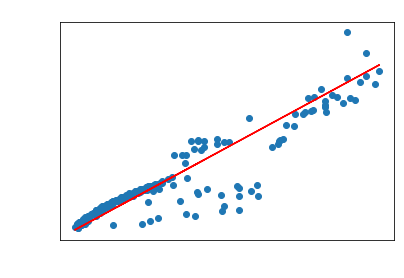

Mean absolute error of the prediction is: 2763.8896003755945
Mean squared error of the prediction is: 19613268.145144287
Root mean squared error of the prediction is: 4428.686954972578
Mean absolute percentage error of the prediction is: 27.37210261727865


In [ ]:
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error

with plt.rc_context({'xtick.color':'white', 'ytick.color':'white', 
                     'axes.labelcolor': 'white'}):
# Add a constant to the model because it's best practice
# to do so every time!
  X_test = sm.add_constant(X_test)

  # You are making predictions here
  y_preds = results.predict(X_test)

  plt.scatter(y_test, y_preds)
  plt.plot(y_test, y_test, color="red")
  plt.xlabel("true values")
  plt.ylabel("predicted values")
  plt.title("Charges: true and predicted values", color='white')
  plt.show()

  print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
  print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
  print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
  print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))